# Evaluation Notebook 

In [23]:
%load_ext autoreload
%autoreload 2
import json
from gensim.summarization.bm25 import BM25
from gensim.models.phrases import Phrases, Phraser
import pandas as pd
pd.set_option('display.max_columns', None)  
pd.set_option('display.expand_frame_repr', False)
pd.set_option('max_colwidth', 1000)
import numpy as np
from multiprocessing import Pool
from functools import partial
import matplotlib.pyplot as plt
import spacy
import seaborn as sns
sns.set()


from tqdm.notebook import tqdm
tqdm.pandas()

import sys
import logging
logging.basicConfig(level=logging.INFO, stream=sys.stdout)


from bm25_retrieval import BM25Retrieval
from evaluation import average_precision, mean_average_precision, mean_average_precision_parallel
from preprocessing import apply_pipeline, Corpus, BasicPreprocessing, BigramPreprocessor, SpacyPreprocessor

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


/Users/d062356/.local/share/virtualenvs/paper_retrieval-GnXOsjmk/lib/python3.7/site-packages/tqdm/std.py:651: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


#### Load corpus using different preprocessing pipelines

In [2]:
base_file =  "../data/kit_expert_2017_papers.csv"

p = [BasicPreprocessing()]
papers_basic = Corpus(base_file, p)

p = [BasicPreprocessing(), BigramPreprocessor()]
papers_basic_bigram = Corpus(base_file, p)

p = [BasicPreprocessing(), SpacyPreprocessor(lemmatization=True)]
papers_basic_lemmatization = Corpus(base_file, p, load_from_cache=True)

p = [BasicPreprocessing(), SpacyPreprocessor(lemmatization=True), BigramPreprocessor()]
papers_basic_lemmatization_bigram = Corpus(base_file, p)

# p = [BasicPreprocessing(), SpacyPreprocessor(combine_noun_chunks=True)]
# papers_basic_nounchunk = Corpus(base_file, p)

# p = [BasicPreprocessing(), SpacyPreprocessor(lemmatization=True, combine_noun_chunks=True)] 
# papers_basic_lemmatization_nounchunk = Corpus(base_file, p)

INFO:root:Start preprocessing pipeline "basic" for file ../data/kit_expert_2017_papers.csv.
INFO:root:Loaded cached preprocessed corpus from ../data/kit_expert_2017_papers_basic
INFO:root:Start preprocessing pipeline "basic_bigrams" for file ../data/kit_expert_2017_papers.csv.
INFO:root:Loaded cached preprocessed corpus from ../data/kit_expert_2017_papers_basic_bigrams
INFO:root:Start preprocessing pipeline "basic_spacy_lemmatization" for file ../data/kit_expert_2017_papers.csv.
INFO:root:Loaded cached preprocessed corpus from ../data/kit_expert_2017_papers_basic_spacy_lemmatization
INFO:root:Start preprocessing pipeline "basic_spacy_lemmatization_bigrams" for file ../data/kit_expert_2017_papers.csv.
INFO:root:Loaded cached preprocessed corpus from ../data/kit_expert_2017_papers_basic_spacy_lemmatization_bigrams


#### Load keywords to use as test data

In [3]:
with open("../data/kit_expert_2017_keywords.json", "r") as file:
    keywords = json.load(file)

#### Define models to evaluate

In [4]:
models = [
    ("BM25 unigrams", partial(BM25Retrieval, corpus = papers_basic)),
    ("BM25 bigrams", partial(BM25Retrieval, corpus = papers_basic_bigram)),
    ("BM25 lemmatization unigrams", partial(BM25Retrieval, corpus = papers_basic_lemmatization)),
    ("BM25 lemmatization bigrams", partial(BM25Retrieval, corpus = papers_basic_lemmatization_bigram)),
#     ("BM25 nounchunk", partial(BM25Retrieval, corpus = papers_basic_nounchunk)),
#     ("BM25 lemmatization nounchunk", partial(BM25Retrieval, corpus = papers_basic_lemmatization_nounchunk)),
]

#### Define test sets 

In [5]:
general_keywords = ("general keywords", [k for k in keywords if k["level"]<=1])
specific_keywords = ("specific_keywords", [k for k in keywords if k["level"]>=2])

#### Evaluate Models

In [6]:
def evaluate_model(model, test_sets):
    model_name, model_factory = model
    model_instance = model_factory()
    results = {model_name:{}}
    total = np.sum([len(test_set[:3000]) for _, test_set in test_sets])
    print(model_name)
    with tqdm(total=total, ncols='50%') as progress:
        for test_set_name, test_set in test_sets:
            data = [{
                "query": keyword_info["keyword"],
                "documents": keyword_info["paper_ids"]
            } for keyword_info in test_set[:3000]]
            mAP = mean_average_precision(model_instance, data, progress.update)
            results[model_name][test_set_name] = mAP
    return pd.DataFrame.from_dict(results, orient="index")
            
def evaluate_models(models, test_sets):
    print("Evaluate Models")
    pool = Pool(4)
    results = pool.map(partial(evaluate_model, test_sets=test_sets), models)
    return pd.concat(results)

In [7]:
results = evaluate_models(models, [general_keywords, specific_keywords])
print("mAP scores for models:")
results

Evaluate Models
BM25 unigrams


BM25 bigrams


BM25 lemmatization unigrams


BM25 lemmatization bigrams






mAP scores for models:


,general keywords,specific_keywords
BM25 unigrams,0.056652,0.522505
BM25 bigrams,0.038118,0.469726
BM25 lemmatization unigrams,0.058848,0.519400
BM25 lemmatization bigrams,0.040045,0.459157


Process ForkPoolWorker-1:
Process ForkPoolWorker-2:
Process ForkPoolWorker-4:
Process ForkPoolWorker-3:
Traceback (most recent call last):
Traceback (most recent call last):
  File "/usr/local/Cellar/python/3.7.4_1/Frameworks/Python.framework/Versions/3.7/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
Traceback (most recent call last):
Traceback (most recent call last):
  File "/usr/local/Cellar/python/3.7.4_1/Frameworks/Python.framework/Versions/3.7/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/local/Cellar/python/3.7.4_1/Frameworks/Python.framework/Versions/3.7/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/usr/local/Cellar/python/3.7.4_1/Frameworks/Python.framework/Versions/3.7/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/usr/local/Cellar/python/3.7.4_1/Frameworks/Python.framework/Versions

In [8]:
k1_grid = np.arange(0.1,1.5,0.1)
models = [(f"BM25 k1={k1:.2f}", partial(BM25Retrieval, corpus=papers_basic, k1=k1)) for k1 in k1_grid]
grid_search_result = evaluate_models(models, [specific_keywords])
grid_search_result

Evaluate Models
BM25 k1=0.10


BM25 k1=0.20


BM25 k1=0.30


BM25 k1=0.40




BM25 k1=0.50




BM25 k1=0.60


BM25 k1=0.70


BM25 k1=0.80




BM25 k1=0.90




BM25 k1=1.00


BM25 k1=1.10


BM25 k1=1.20




BM25 k1=1.30



BM25 k1=1.40


,specific_keywords
BM25 k1=0.10,0.543085
BM25 k1=0.20,0.544039
BM25 k1=0.30,0.544757
BM25 k1=0.40,0.545146
BM25 k1=0.50,0.544213
BM25 k1=0.60,0.542758
BM25 k1=0.70,0.541220
BM25 k1=0.80,0.540121
BM25 k1=0.90,0.537778
BM25 k1=1.00,0.535502


Process ForkPoolWorker-5:
Process ForkPoolWorker-7:
Process ForkPoolWorker-6:
Process ForkPoolWorker-8:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/usr/local/Cellar/python/3.7.4_1/Frameworks/Python.framework/Versions/3.7/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/usr/local/Cellar/python/3.7.4_1/Frameworks/Python.framework/Versions/3.7/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
Traceback (most recent call last):
  File "/usr/local/Cellar/python/3.7.4_1/Frameworks/Python.framework/Versions/3.7/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/local/Cellar/python/3.7.4_1/Frameworks/Python.framework/Versions/3.7/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/usr/local/Cellar/python/3.7.4_1/Frameworks/Python.framework/Versions

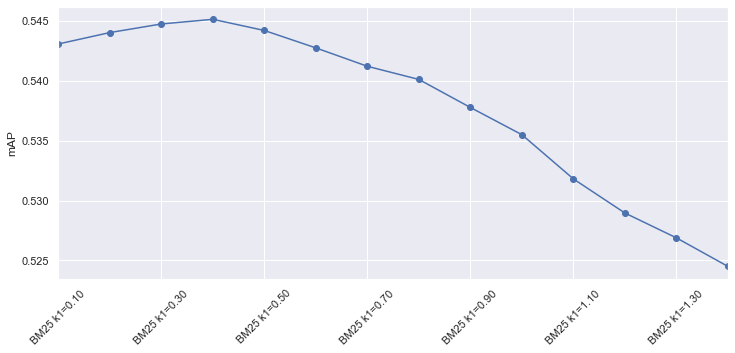

In [32]:
ax = grid_search_result.plot(figsize=(12,5), style="-bo", rot=45, legend=False)
ax.set_ylabel("mAP");